# 🐡 The sharp points of Rockpool 🐚

In [1]:
# - Switch off warnings
import warnings

warnings.filterwarnings("ignore")

# - Rockpool imports
from rockpool import TSContinuous

# - General imports and configuration
import numpy as np

import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

## 🦀 How to use sampled time series data (in)correctly in Rockpool
Time series data loaded from elsewhere probably comes in a clocked raster format. You can easily use this data in Rockpool, but there are a couple of tricky points to watch out for.

### Wrong: how to generate a time base for clocked data

In [2]:
T = 1000
dt = 1e-3
data = np.random.rand(T)
t_start = 23.6
time_base = np.arange(t_start, t_start + len(data) * dt, dt)

In [3]:
time_base = np.arange(T) * dt + t_start

### Wrong: how to define a time series from clocked data

Say we have a 20-second sample, sampled on a 100ms clock. Let's convert this into a continuous time series:

In [4]:
dt = 100e-3
T = round(20 / dt)
data = np.random.rand(T)
time_base = np.arange(len(data)) * dt

ts = TSContinuous(time_base, data)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 19.900000000000002. Samples: 200. Channels: 1

In [5]:
ts = TSContinuous(time_base, data, t_stop=20.0)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 20.0. Samples: 200. Channels: 1

In [6]:
ts = TSContinuous.from_clocked(data, dt=dt)
ts

non-periodic TSContinuous object `unnamed` from t=0.0 to 20.000000000000004. Samples: 200. Channels: 1

## 🐚 Defining extents for `TSEvent` time series data

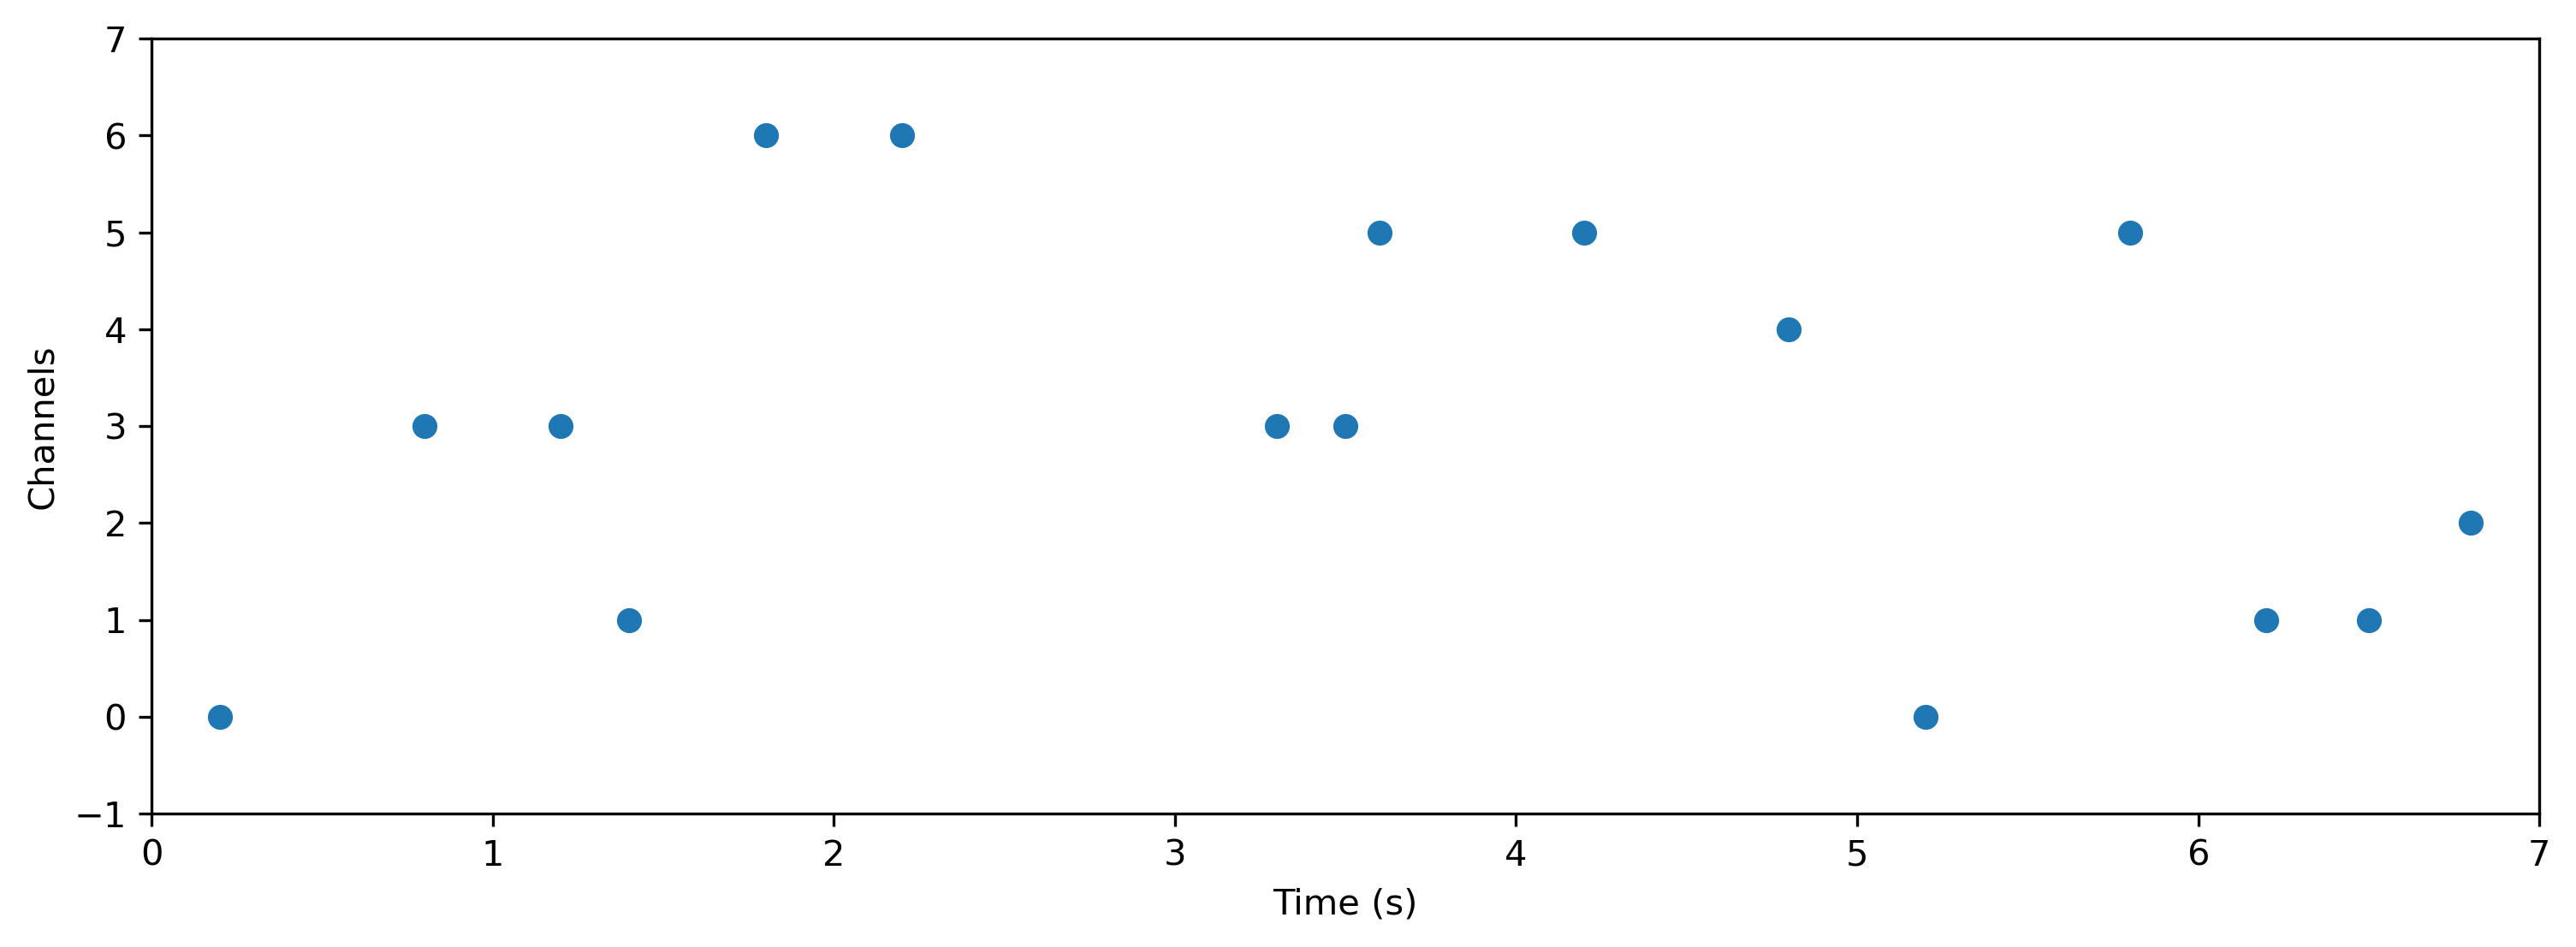

In [7]:
from rockpool import TSEvent
from matplotlib import pyplot as plt

times = [0.2, 0.8, 1.2, 1.4, 1.8, 2.2, 3.3, 3.5, 3.6, 4.2, 4.8, 5.2, 5.8, 6.2, 6.5, 6.8]
channels = [0, 3, 3, 1, 6, 6, 3, 3, 5, 5, 4, 0, 5, 1, 1, 2]
ts = TSEvent(times, channels, t_start=0.0, t_stop=7.0)
ts.plot();

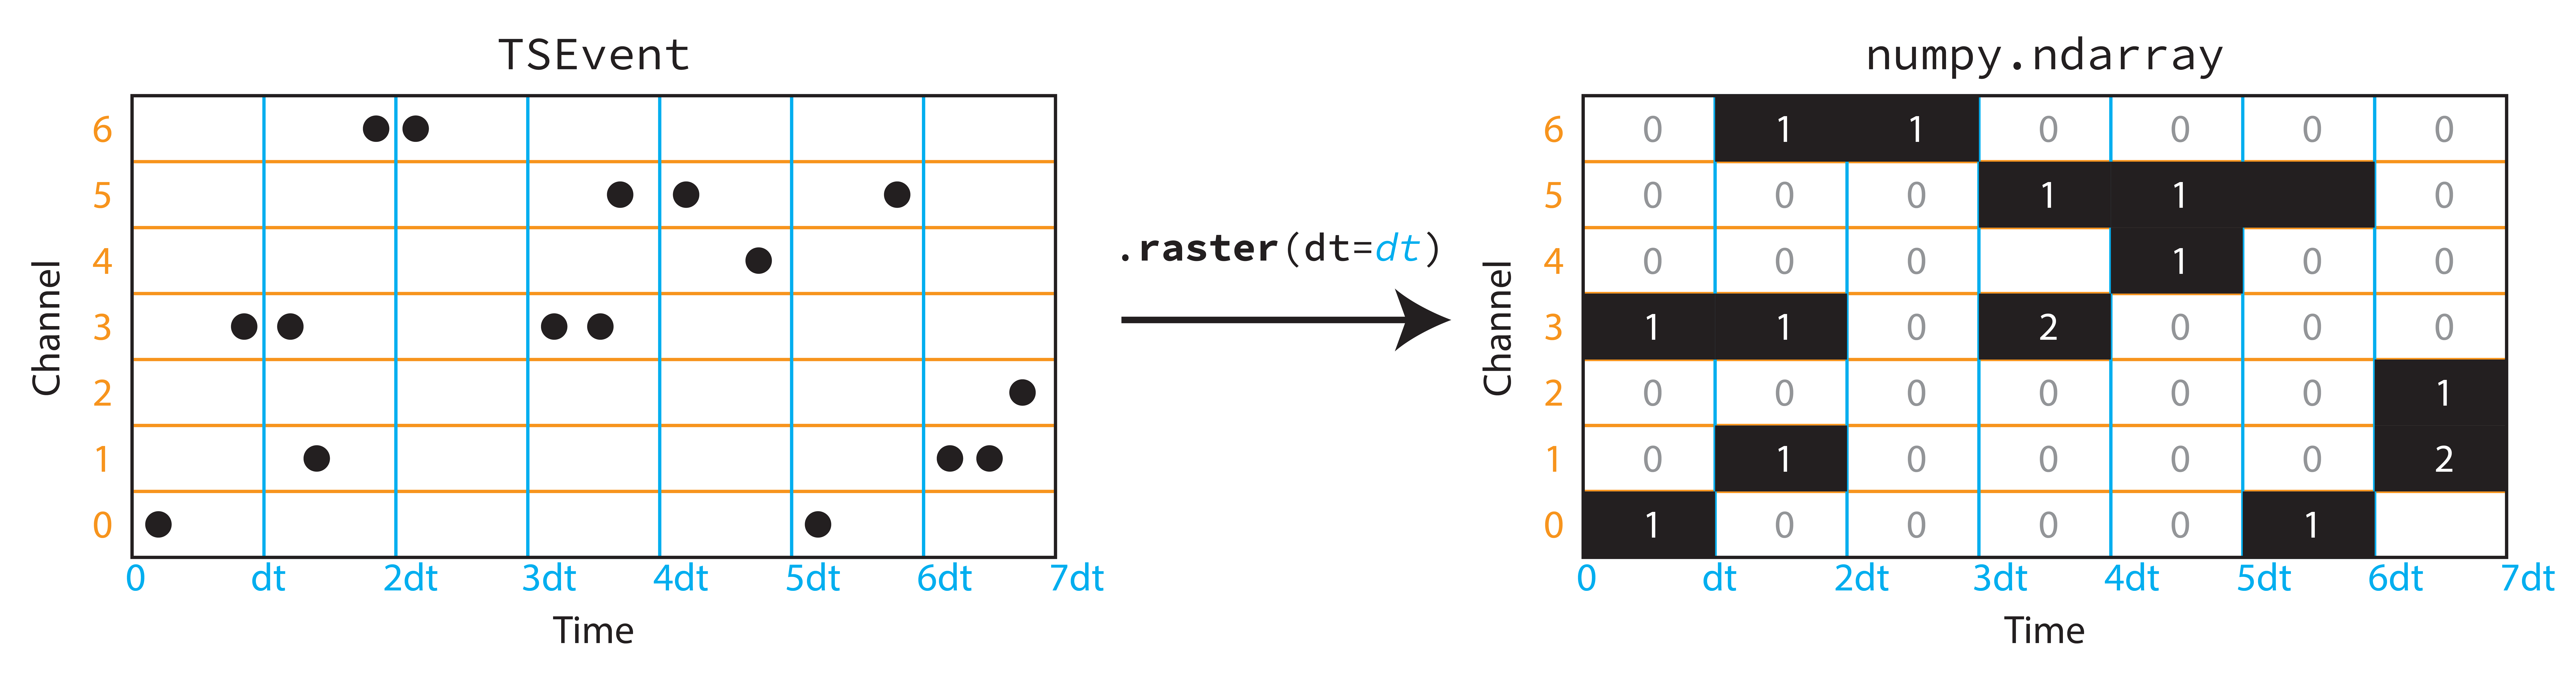

In [8]:
from IPython.display import Image

Image("TSEvent_to_raster.png")

```python
def raster(
    dt: float,
    t_start: float=None,
    t_stop: float=None,
    num_timesteps: int=None,
    channels: numpy.ndarray=None,
    add_events: bool=False,
    include_t_stop: bool=False,
) -> numpy.ndarray:
```

In [9]:
tsBad = TSEvent(times, channels, t_stop=7.0, name="No extents 🤢🤬")
print(tsBad)

tsGood = TSEvent(times, channels, t_start=0.0, t_stop=7.0, name="With extents 😇🥰")
print(tsGood)

non-periodic `TSEvent` object `No extents 🤢🤬` from t=0.2 to 7.0. Channels: 7. Events: 16
non-periodic `TSEvent` object `With extents 😇🥰` from t=0.0 to 7.0. Channels: 7. Events: 16


## 🐡 `TimeSeries` and `Module`s share an explicit global time base

tmod: TimedModuleWrapper  with shape (1, 1) {
    Rate '_module' with shape (1,)
} with Rate '_module' as module


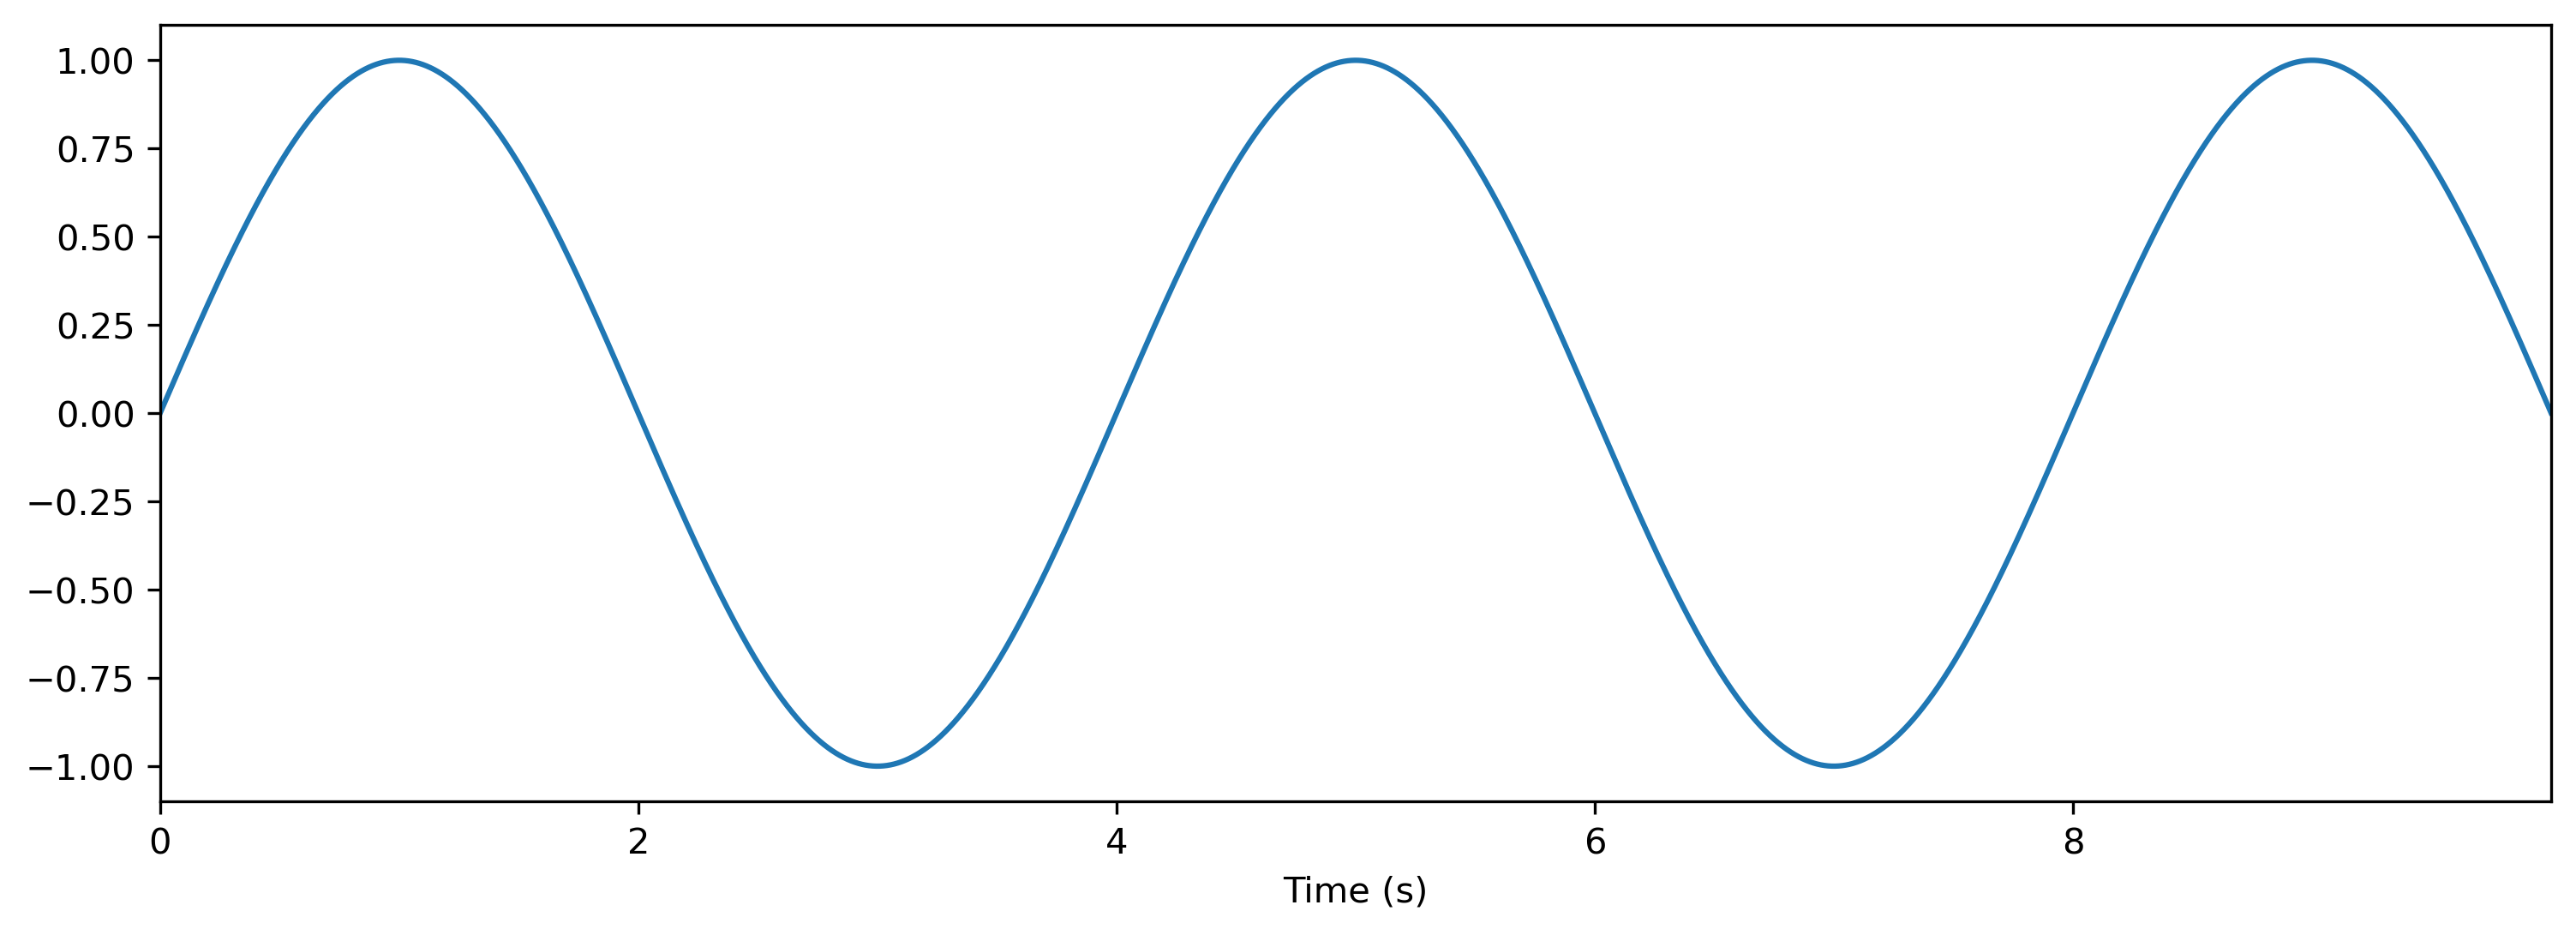

In [10]:
# - Imports
from rockpool.nn.modules import Rate
from rockpool import TSContinuous

# - Define a Timed module with a single rate neuron
tmod = Rate(1).timed()
print("tmod:", tmod)

# - Define a time series
dt = 1e-3
data = np.sin(np.arange(0, 10, dt) / 4 * (2 * np.pi))
ts_input = TSContinuous.from_clocked(data, dt=dt)
ts_input.plot();

Now we evolve `tmod` using `ts_input`, and look at the result.

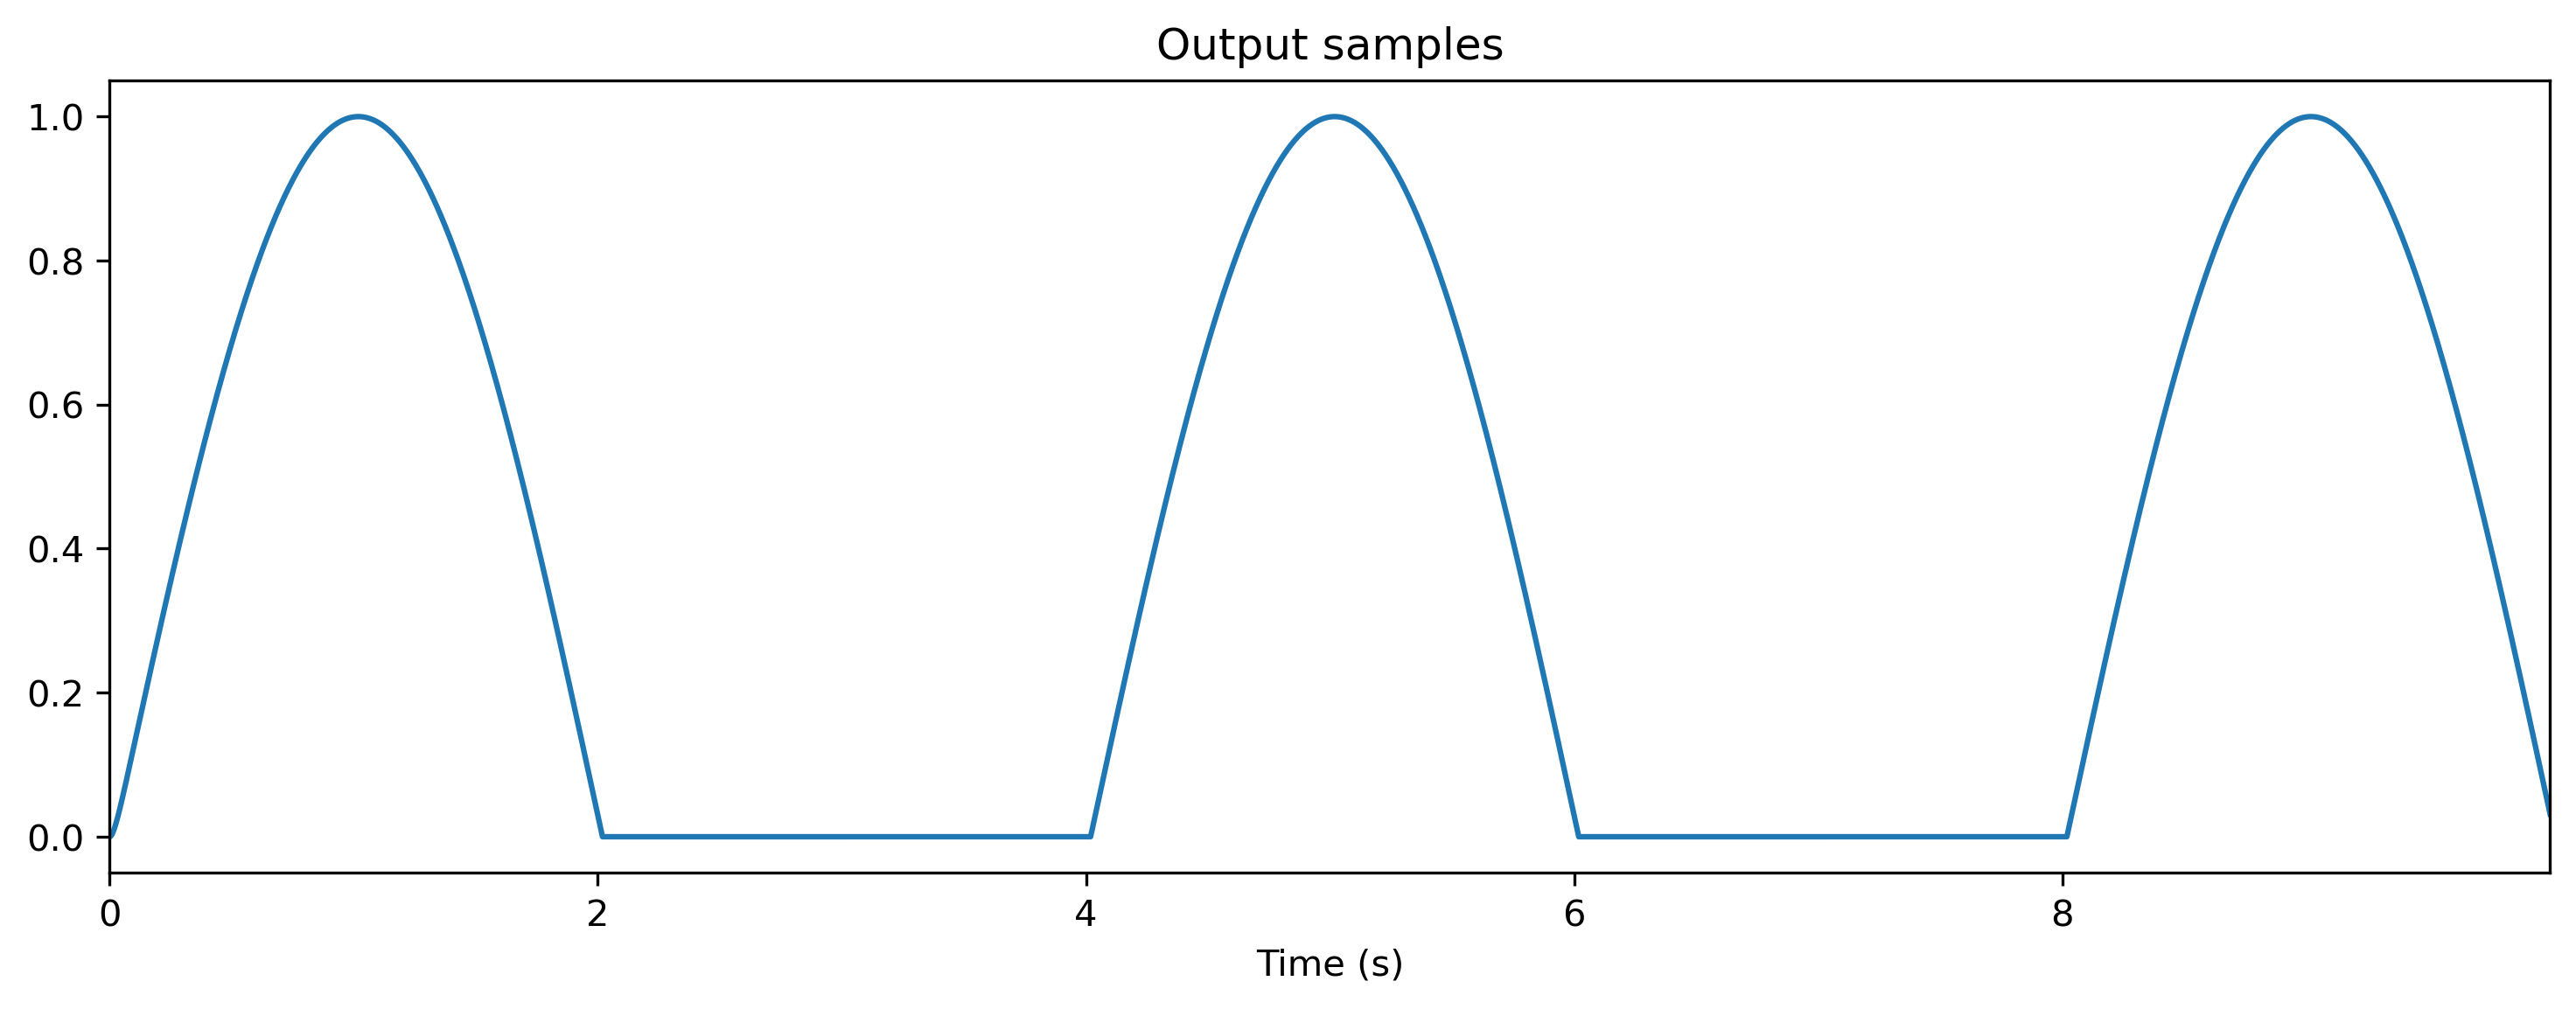

In [11]:
output_ts, _, _ = tmod(ts_input)
output_ts.plot()

But if we try to evolve `mod` again in the same way, we recieve an error.

In [12]:
tmod(ts_input);

ValueError: TimedModuleWrapper Cannot determine an appropriate evolution duration. 'ts_input' finishes before the current evolution time.

In [13]:
ts_input = TSContinuous.from_clocked(data, dt=dt, t_start=tmod.t)
print("ts_input:", ts_input)
output, _, _ = tmod(ts_input)

ts_input: non-periodic TSContinuous object `unnamed` from t=10.0 to 20.000000000000004. Samples: 10000. Channels: 1


In [14]:
# - Using `.start_at()`
tmod(ts_input.start_at(tmod.t))

# - Using `.delay()`
tmod(ts_input.delay(tmod.t - ts_input.t_start));

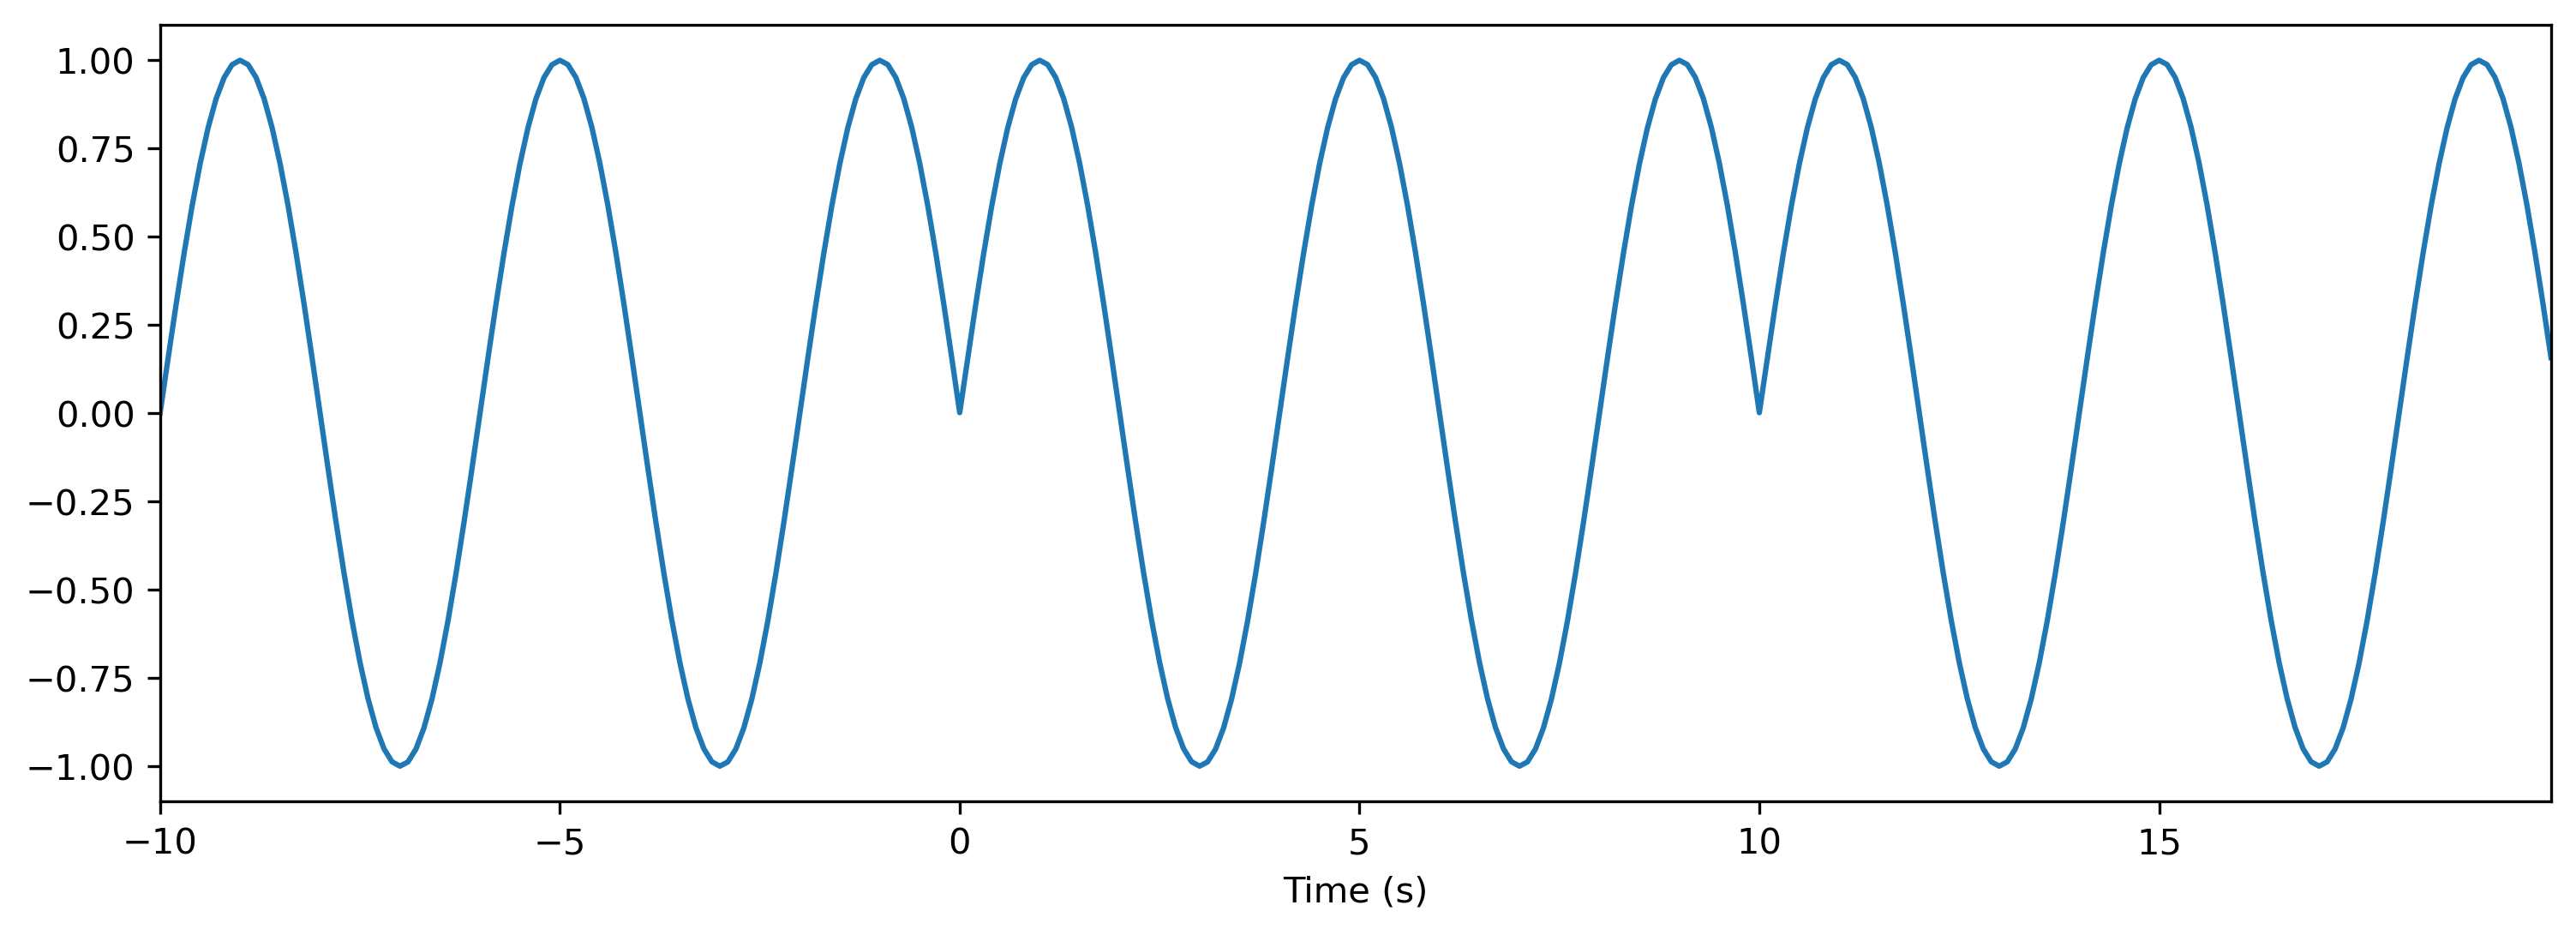

In [15]:
ts_input = TSContinuous.from_clocked(data, dt=dt, periodic=True)
ts_input.plot(np.arange(-10, 20, 0.1));

In [16]:
tmod(ts_input)
tmod(ts_input);

## 🦀 `Module`s in Rockpool are dynamical systems, and don't get reset implicitly